# 1. Prepare data

res = (420, 236), n_data = 99120
train_data.shape = torch.Size([99120, 1])
uv.shape = torch.Size([99120, 1])


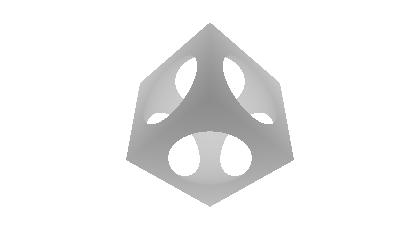

In [23]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np

data_img = Image.open("./test_small.png")
res = data_img.size
n_data = res[0] * res[1]
print(f"res = {res}, n_data = {n_data}")

data_img_tensor = transforms.ToTensor()(data_img)[0]
train_data = torch.reshape(
        data_img_tensor,
        (n_data, 1))

print(f"train_data.shape = {train_data.shape}")

# uv = np.mgrid[0:res[0]:1, 0:res[1]:1].reshape(2,-1).T
# uv = torch.Tensor(uv).to(torch.long)
# print(uv.shape)

uv = torch.reshape(
    torch.Tensor(np.array(range(0, res[0]*res[1]))),
    (n_data, 1))

print(f"uv.shape = {uv.shape}")

transforms.ToPILImage()(data_img_tensor)

# 2. Prepare Data Batch

In [24]:
from torch.utils.data import Dataset, DataLoader

batch_size = 128

class customDataSet(Dataset):
    def __init__(self, uv, data):
        self.uv = uv 
        self.data = data
        assert(self.data.shape[0] == n_data)

    def __len__(self):
        return self.data.shape[0] 
    
    def __getitem__(self, idx):
        input = self.uv[idx]
        label = self.data[idx]
        return input, label

train_dataset = customDataSet(uv, train_data)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# 3. Train MLP

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


class sdf_net(nn.Module):
    def __init__(self):
        super(sdf_net, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x 

model = sdf_net().to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters())

def train(input, labels, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()

    pred = model(input)
    loss = loss_fn(pred, labels)
    
    loss.backward()
    optimizer.step()

    return loss

def validate():
    model.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            inputs = inputs.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) # the class with the highest energy is what we choose as prediction
            total += labels.size(0)
            correct += ( abs(predicted - labels) < 0.1 ).sum().item()

    acc = (100 * correct / total)
    print(f'Accuracy of the network on the {total} test data pair:{acc:2f}'  )
    return acc 


epoch = 10
for e in range(epoch):
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # print(i)

        inputs, labels = data # get the inputs; data is a list of [inputs, labels]
        
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)

        loss = train(inputs, labels, model, loss_fn, optimizer)
        running_loss += loss.item()

        n = 150
        if i % n == n-1:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (e + 1, i + 1, running_loss / n))
            running_loss = 0.0
    
    acc = validate()

Using cuda device
[1,   150] loss: 2370257.787
[1,   300] loss: 2.263
[1,   450] loss: 1.274
[1,   600] loss: 1.290
[1,   750] loss: 1.288
Accuracy of the network on the 99120 test data pair:0.000000
[2,   150] loss: 1.287
[2,   300] loss: 1.303
[2,   450] loss: 1.279
[2,   600] loss: 1.297
[2,   750] loss: 1.258
Accuracy of the network on the 99120 test data pair:0.000000
[3,   150] loss: 1.306
[3,   300] loss: 1.259
[3,   450] loss: 1.299
[3,   600] loss: 1.279
[3,   750] loss: 1.287
Accuracy of the network on the 99120 test data pair:0.000000
[4,   150] loss: 1.277
[4,   300] loss: 1.296
[4,   450] loss: 1.294
[4,   600] loss: 1.269
[4,   750] loss: 1.271
Accuracy of the network on the 99120 test data pair:0.000000
[5,   150] loss: 1.266
[5,   300] loss: 1.272
[5,   450] loss: 1.267
[5,   600] loss: 1.307
[5,   750] loss: 1.280
Accuracy of the network on the 99120 test data pair:0.000000
[6,   150] loss: 1.290
[6,   300] loss: 1.303
[6,   450] loss: 1.238
[6,   600] loss: 1.275


KeyboardInterrupt: 

In [ ]:
train_data[61736]

tensor([1.])

In [ ]:
fit = model(uv.to(device)).cpu().detach()
print(fit)

(fit - train_data.cpu().detach()).norm()

tensor([[1.0786],
        [1.0829],
        [1.0519],
        ...,
        [1.0285],
        [1.0285],
        [1.0285]])


tensor(44.8920)

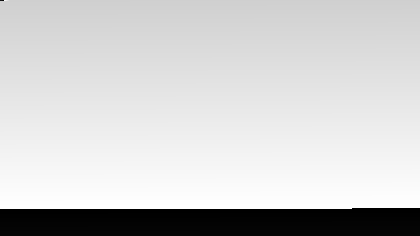

In [ ]:
fit = torch.reshape(
    fit,
    (res[1], res[0])
)

fit_to_pil_img = transforms.ToPILImage()(fit)
fit_to_pil_img